# Tensorflow and Keras model
## Imports and version check

In [87]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.6.0
True


## Configuration of GPU and plots

In [88]:
plt.style.use("ggplot")
np.set_printoptions(precision=3, suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read CSV file

In [89]:
# current_path = os.path.dirname(os.path.realpath(__file__))
current_path = os.path.abspath('')
training_data_path = os.path.abspath(
    os.path.join(current_path, '..', '..', 'data', 'TRAINING_DATA_CYCLE_LENGTHS_AS_FEATURES.csv'))
csv_data = pd.read_csv(training_data_path)
csv_data.head()

,1,2,3,4,5,6,7,8,9,10,...,keff64,keff65,keff66,keff67,keff68,keff69,ppf_start,ppf_max,ppf_end,cycle_length_in_days
0,505.236340,391.189251,507.876623,347.487252,391.189251,549.372403,391.189251,188.446900,535.587659,535.587659,...,0.945909,0.944285,0.942662,0.941040,0.939418,0.937797,4.433,5.608,1.381,411.474034
1,535.587659,323.596645,323.596645,488.564011,488.564011,488.564011,188.446900,347.487252,535.587659,507.876623,...,0.952956,0.951327,0.949698,0.948070,0.946443,0.944816,2.690,2.690,1.320,432.732046
2,323.596645,507.876623,535.587659,505.236340,323.596645,549.372403,488.564011,391.189251,535.587659,505.236340,...,0.951664,0.950032,0.948401,0.946772,0.945143,0.943517,4.269,5.356,1.324,429.459459
3,323.596645,507.876623,391.189251,535.587659,188.446900,549.372403,188.446900,535.587659,323.596645,323.596645,...,0.947787,0.946196,0.944604,0.943012,0.941420,0.939828,5.760,7.038,1.422,409.351467
4,507.876623,488.564011,488.564011,488.564011,323.596645,535.587659,507.876623,323.596645,488.564011,488.564011,...,0.947005,0.945420,0.943835,0.942251,0.940666,0.939082,2.572,2.572,1.424,408.764331


## Split data into train and test

In [90]:
csv_dataset = csv_data.copy()
train_dataset = csv_dataset.sample(frac=0.8, random_state=0)
test_dataset = csv_dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,8000.0,428.161767,114.771627,188.446900,347.487252,488.564011,507.876623,549.372403
2,8000.0,426.248704,115.914282,188.446900,347.487252,488.564011,507.876623,549.372403
3,8000.0,425.721939,114.656662,188.446900,347.487252,488.564011,507.876623,549.372403
4,8000.0,425.922168,115.161552,188.446900,347.487252,488.564011,507.876623,549.372403
5,8000.0,426.464525,115.320726,188.446900,347.487252,488.564011,507.876623,549.372403
...,...,...,...,...,...,...,...,...
keff69,8000.0,0.942628,0.007630,0.907837,0.937509,0.942794,0.947944,0.968298
ppf_start,8000.0,3.233506,0.787582,1.919000,2.721000,3.037000,3.496000,9.917000
ppf_max,8000.0,3.529833,1.259520,1.979000,2.722000,3.087000,3.879250,12.390000
ppf_end,8000.0,1.365294,0.047191,1.238000,1.332000,1.361000,1.394000,1.587000


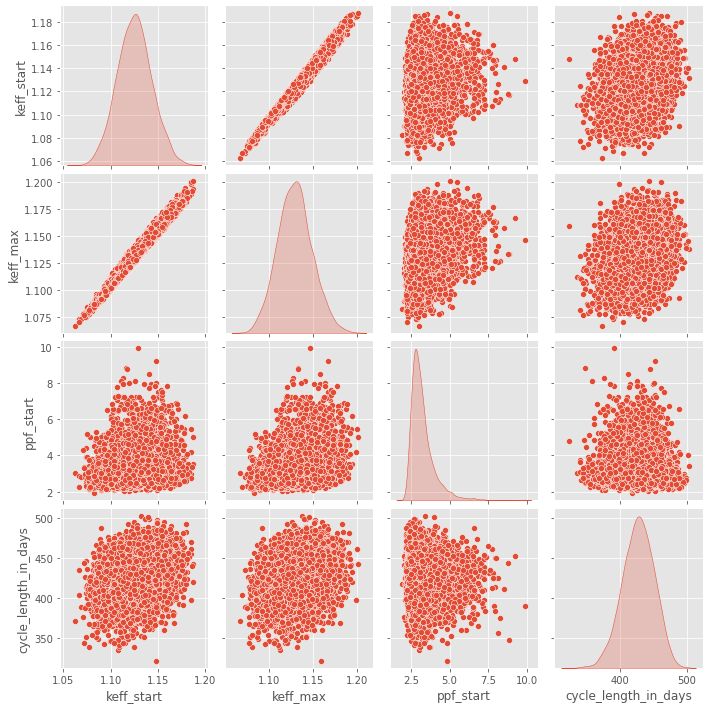

In [91]:
sns.pairplot(csv_dataset[['keff_start', 'keff_max', 'ppf_start', 'cycle_length_in_days']], diag_kind='kde')
# sns.pairplot(train_dataset[['ppf_start', 'ppf_max', 'ppf_end', 'cycle_length_in_days']], diag_kind='kde')

## Split features from labels
Separate target values from the values on which the neural network is being trained.

In [92]:
labels = ["keff_max", "ppf_max", "cycle_length_in_days"]

x_train = tf.convert_to_tensor(train_dataset.iloc[:, :32])
y_train = tf.convert_to_tensor(train_dataset.get(labels))
x_test = tf.convert_to_tensor(test_dataset.iloc[:, :32])
y_test = tf.convert_to_tensor(test_dataset.get(labels))

## Normalization
Normalization layer normalizes values along rows.

In [93]:
normalizer = layers.Normalization(axis=1, mean=None)
normalizer.adapt(x_train)
print("First row: {} \nNormalized: {}".format(x_train[0], normalizer(x_train[0])))

First row: [188.447 507.877 505.236 391.189 507.877 347.487 505.236 391.189 549.372
 347.487 391.189 535.588 507.877 507.877 535.588 507.877 347.487 507.877
 549.372 505.236 188.447 549.372 488.564 507.877 188.447 188.447 347.487
 391.189 488.564 549.372 505.236 347.487] 
Normalized: [[-2.089  0.704  0.694 -0.302  0.706 -0.699  0.683 -0.305  1.085 -0.683
  -0.312  0.957  0.728  0.719  0.964  0.721 -0.71   0.697  1.081  0.689
  -2.085  1.086  0.538  0.712 -2.052 -2.07  -0.679 -0.296  0.545  1.076
   0.686 -0.675]]


# Model
## Layers
For the network with two hidden layers $NHN1 = m\cdot r^{2}$ and $NHN2 = m\cdot r$ where $r=(n\cdot m)^{1/3}$.  
$n$ - number of input neurons, $m$ - number of output neurons.

[Bohdan Macukow. Neural Networks – State of Art, BriefHistory, Basic Models and Architecture.]

| No. output neurons | r | NHN1 | NHN2 |
| --- | --- | --- | --- |
| 1 | x | 0 | x |
| 3 | 4.5788 | 62.8977 | 13.7365 |

In [94]:
weight_initializer = keras.initializers.glorot_uniform()

# model = keras.Sequential([
#     keras.Input(shape=(32,), name="input-features"),
#     normalizer,
#     layers.Dense(units=50,
#                  activation=keras.activations.gelu,
#                  kernel_initializer=weight_initializer),
#     layers.Dense(units=30,
#                  activation=keras.activations.gelu,
#                  kernel_initializer=weight_initializer),
#     layers.Dense(units=20,
#                  activation=keras.activations.gelu,
#                  kernel_initializer=weight_initializer),
#     layers.Dense(units=30,
#                  activation=keras.activations.gelu,
#                  kernel_initializer=weight_initializer),
#     layers.Dense(units=50,
#                  activation=keras.activations.gelu,
#                  kernel_initializer=weight_initializer),
#     layers.Dense(units=1, name="output")
# ])
model = keras.Sequential([
    keras.Input(shape=(32,), name="input-features"),
    normalizer,
    layers.Dense(units=63,
                 activation=keras.activations.relu,
                 kernel_initializer=weight_initializer),
    layers.Dense(units=14,
                 activation=keras.activations.relu,
                 kernel_initializer=weight_initializer),
    layers.Dense(units=len(labels), name="output")
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_82 (Dense)             (None, 63)                2079      
_________________________________________________________________
dense_83 (Dense)             (None, 14)                896       
_________________________________________________________________
output (Dense)               (None, 3)                 45        
Total params: 3,085
Trainable params: 3,020
Non-trainable params: 65
_________________________________________________________________


## Compile
Compile methods takes few methods: optimizer, loss - defined loss function, metrics - which metrics should be used when
learning and callbacks - call of some function after each epoch.

In [95]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error,
             keras.metrics.mean_absolute_error]
)

## Fit
Fit the model to the data. Callbacks are used after/before each epoch to change the parameters during fitness.

In [96]:
%%time
NUM_EPOCHS = 2
history = model.fit(
    x_train,
    y_train,
    epochs=NUM_EPOCHS,
    verbose=1,
    shuffle=True,
    # batch_size=32,  # default 32
    validation_data=(x_test, y_test),
)

Epoch 1/2
250/250 [==============================] - 1s 4ms/step - loss: 8349.7637 - mean_squared_error: 8349.7637 - mean_absolute_error: 31.4955 - val_loss: 335.7813 - val_mean_squared_error: 335.7813 - val_mean_absolute_error: 9.3502

In [97]:
history.history.keys()
# history.history['mean_squared_error']

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])

#### Plot loss and other parameters from history

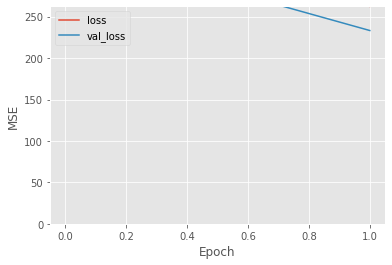

In [98]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, max(history.history['loss'][1:])])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss.svg')


plot_loss(history)

## Evaluation for each parameter

In [99]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

63/63 [==============================] - 0s 3ms/step - loss: 233.2612 - mean_squared_error: 233.2612 - mean_absolute_error: 7.7188
test loss, test acc: [233.26116943359375, 233.26116943359375, 7.718807220458984]


In [100]:
x = x_test[:2]
print(y_test[:2])
y = model.predict(x)
print(y)

tf.Tensor(
[[  1.163   5.608 411.474]
 [  1.121   2.382 439.714]], shape=(2, 3), dtype=float64)
[[  2.474   3.473 415.859]
 [  1.86    5.315 454.156]]


# Hyperparameter tuning

### Clear any logs from previous runs

In [110]:
current_path = os.path.dirname(os.path.realpath("__file__"))
data_path = os.path.abspath(os.path.join(current_path, '..', '..', 'data'))
LOG_DIR = os.path.join(data_path, 'logs', 'hparam_tuning')

do_train_hyperparameters = True
if os.path.exists(LOG_DIR):
    print("--- Logs folder already exists! ---".upper())
    do_train_hyperparameters = False

In [111]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([60,70]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0001, 0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#, 'sgd']))

METRIC_ACCURACY = 'mean_squared_error'

with tf.summary.create_file_writer(os.path.join(LOG_DIR, 'config')).as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='MSE')],
  )

In [112]:
weight_initializer = keras.initializers.glorot_uniform()

def train_test_model(run_dir, hparams):
    model = keras.Sequential([
        keras.Input(shape=(32,), name="input-features"),
        normalizer,
        layers.Dense(units=hparams[HP_NUM_UNITS],
                     activation=keras.activations.relu,
                     kernel_initializer=weight_initializer),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(units=14,
                     activation=keras.activations.relu,
                     kernel_initializer=weight_initializer),
        layers.Dense(units=len(labels), name="output")
    ])

    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=keras.losses.mean_squared_error,
        metrics=[keras.metrics.mean_squared_error,
                 keras.metrics.mean_absolute_error]
    )

    model.fit(x_train, y_train, epochs=3,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(run_dir),  # log metrics
                  hp.KerasCallback(run_dir, hparams),  # log hparams
              ])

    _, mse, _ = model.evaluate(x_test, y_test)
    return mse


def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        mse = train_test_model(run_dir, hparams)
        # tf.summary.scalar(METRIC_ACCURACY, mse, step=1)


In [114]:
import sys
session_num = 0

if not do_train_hyperparameters:
    sys.exit(1)

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-{}-{}-{}-{}".format(session_num, optimizer,num_units,dropout_rate)
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(os.path.join(LOG_DIR, run_name), hparams)
            session_num += 1

--- Starting trial: run-0-adam-60-0.0001
{'num_units': 60, 'dropout': 0.0001, 'optimizer': 'adam'}
Epoch 1/3
250/250 [==============================] - 4s 13ms/step - loss: 50908.6484 - mean_squared_error: 50908.6484 - mean_absolute_error: 130.2118 - ETA: 7s - loss: 60763.7656 - mean_squared_error: 60763.7656 - mean_absolute_error: 143.5473 

## Visualize results using TensorBoard
### Load the TensorBoard notebook extension
python -m tensorboard.main --logdir=logs/


In [105]:
import tensorboard as tb
experiment_id = "u3fWtMznQpWBAGdFlbXRdg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,run-0,batch_loss,1,59874.507812
1,run-0,batch_loss,2,59680.136719
2,run-0,batch_loss,3,60147.843750
3,run-0,batch_loss,4,60311.191406
4,run-0,batch_loss,5,60735.136719
...,...,...,...,...
18003,run-7,batch_mean_squared_error,747,NaN
18004,run-7,batch_mean_squared_error,748,NaN
18005,run-7,batch_mean_squared_error,749,NaN
18006,run-7,batch_mean_squared_error,750,NaN
